In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

Prompt used to generate a bunch of queries
```
I am implementing a chat for a online shop. This shop sells anything (for example, think about Amazon). I want to test my system with user queries. Generate a list of user queries in a JSON format. Generate for example 1000 queries using the format ["query1", "query2", ...]
```
Then, I continued the chat using `Continue`

# Tools

In [1]:
def most_common(lst):
    if len(lst) > 0:
        return max(set(lst), key=lst.count)
    else:
        return -1

def compute_one_rate(articles_numbers):
    positions, counts = np.unique(articles_numbers, return_counts=True)
    positions_count = {str(position): n for position, n in zip(positions, counts)}
    one_rate = positions_count['1'] / len(articles_numbers)
    return one_rate


def compute_minmax_diff(articles_numbers):
    positions, counts = np.unique(articles_numbers, return_counts=True)
    if positions[0] == -1:
        positions = positions[1:]
        counts = counts[1:]
    minmax_diff = max(counts) - min(counts)
    return minmax_diff


def load_results(path):
    with open(path, 'r') as f:
        data = json.load(f)

    results = [
        most_common([replica['parsed_response']['article_number'] for replica in sample if replica['parsed_response'] is not None])
        for sample in data['results']
    ]

    return results

# Single run

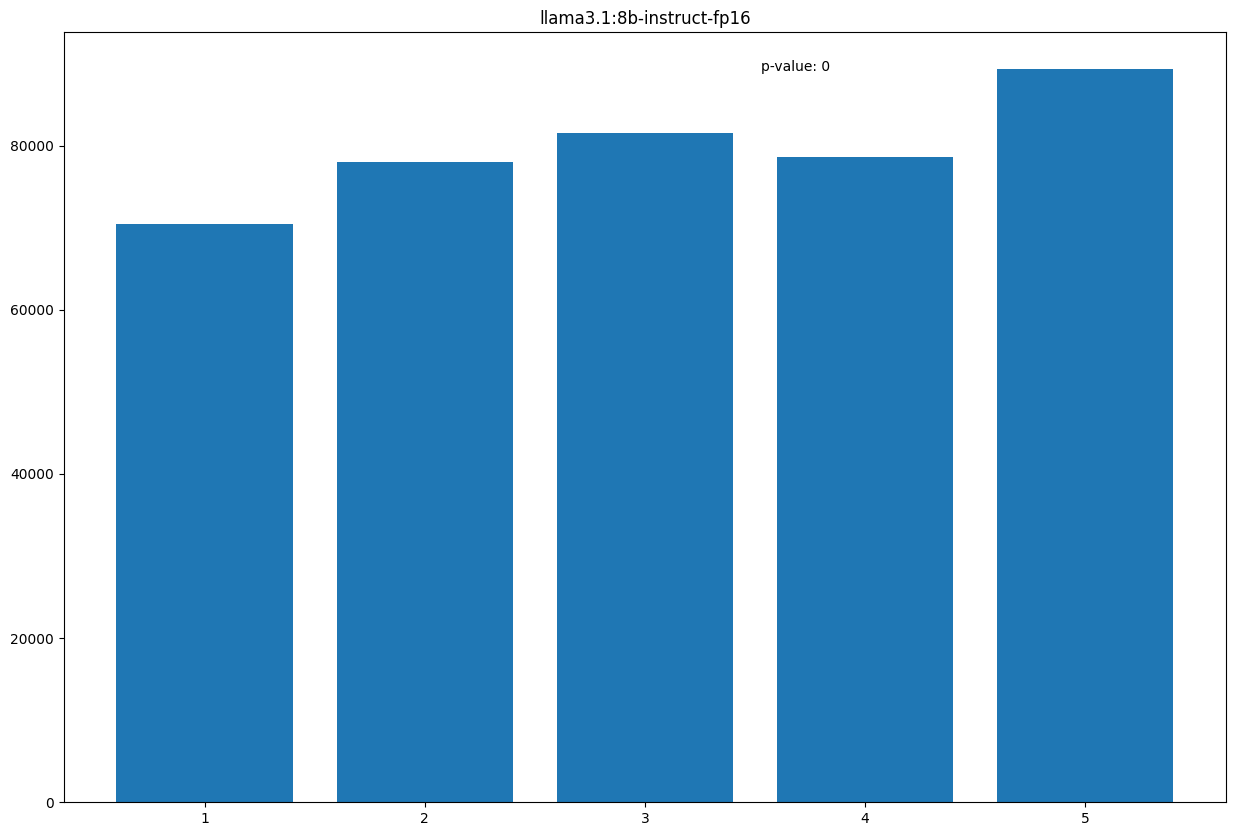

In [2]:
experiment_path = os.path.join('..', 'results', 'self_bias_analysis', 'many_products_paraphrase', 'many_samples__big', 'evaluation_llama8b.json')

with open(experiment_path, 'r') as f:
    data = json.load(f)

with open(os.path.join('..', data['input_dataset']), 'r') as f:
    dataset = json.load(f)

top_k = dataset['top_k']

articles_numbers = [
    sample['predicted_pos'] for sample in data['results'] if sample['parsed_response'] is not None and sample['predicted_pos'] <= top_k and sample['predicted_pos'] >= 1
]

positions, counts = np.unique(articles_numbers, return_counts=True)


fixed_articles_numbers = list(map(lambda pos: pos-1, articles_numbers))
bincounts = np.bincount(fixed_articles_numbers, minlength=top_k-1)
expected = [len(fixed_articles_numbers)/top_k] * top_k
chi2_stat, p_value = chisquare(bincounts, f_exp=expected)

plt.rcParams['figure.figsize'] = [15, 10]
plt.bar(positions, counts)
plt.text(x=0.6, y=0.95, s=f"p-value: {p_value:.5g}", transform=plt.gca().transAxes, color='red' if p_value > 0.05 else 'black')
plt.title(data['recommender_llm'])
plt.show()

In [4]:
positions_count = {
    str(position): n for position, n in zip(positions, counts)
}


one_rate = positions_count['1'] / len(articles_numbers)
error_rate = positions_count['-1'] if '-1' in positions_count else 0 / len(articles_numbers)
counts_mean = np.mean(counts)
counts_std = np.std(counts)


print(f'One rate: {one_rate*100:.2f}%')
print(f'Error rate: {error_rate*100:.2f}%')
print(f'Histogram stats: {counts_mean:.2f} (+-{counts_std:.4f})')

One rate: 3.10%
Error rate: 0.00%
Histogram stats: 47.62 (+-38.6677)


# Model quantization

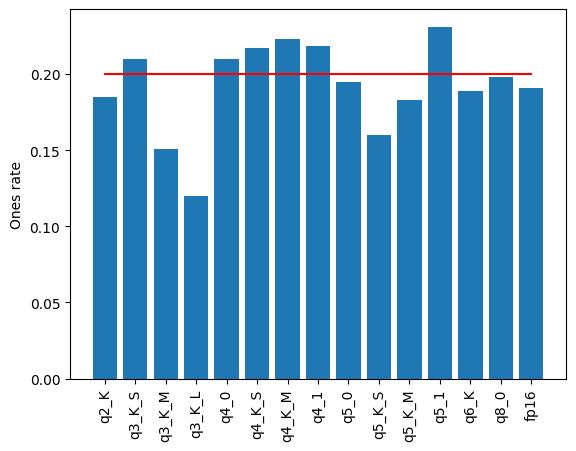

In [5]:
base_dir = os.path.join('..', 'results', 'variance_reduction', 'icl_order__quantization_level__top_5')
model_name = 'llama3.1'
model_version = '8b-instruct'
quantization_levels = [
    'q2_K',   # 3.2 GB
    'q3_K_S', # 3.7 GB
    'q3_K_M', # 4.0 GB
    'q3_K_L', # 4.3 GB
    'q4_0',   # 4.7 GB
    'q4_K_S', # 4.7 GB
    'q4_K_M', # 4.9 GB
    'q4_1',   # 5.1 GB
    'q5_0',   # 5.6 GB
    'q5_K_S', # 5.6 GB
    'q5_K_M', # 5.7 GB
    'q5_1',   # 6.1 GB
    'q6_K',   # 6.6 GB
    'q8_0',   # 8.5 GB
    'fp16'    # 16 GB
]
plot_name = 'Ones rate'

results = {q_level: load_results(os.path.join(base_dir, f'{model_name}:{model_version}-{q_level}.json')) for q_level in quantization_levels}

data_dict = {
    'Ones rate': {q_level: compute_one_rate(articles_numbers) for q_level, articles_numbers in results.items()},
    'Min/max diff': {q_level: compute_minmax_diff(articles_numbers) for q_level, articles_numbers in results.items()}
}

plt.bar(data_dict[plot_name].keys(), data_dict[plot_name].values())
plt.plot(data_dict[plot_name].keys(), [1/5]*len(data_dict[plot_name]), color='red')
plt.xticks(rotation=90)
plt.ylabel(plot_name)
plt.show()

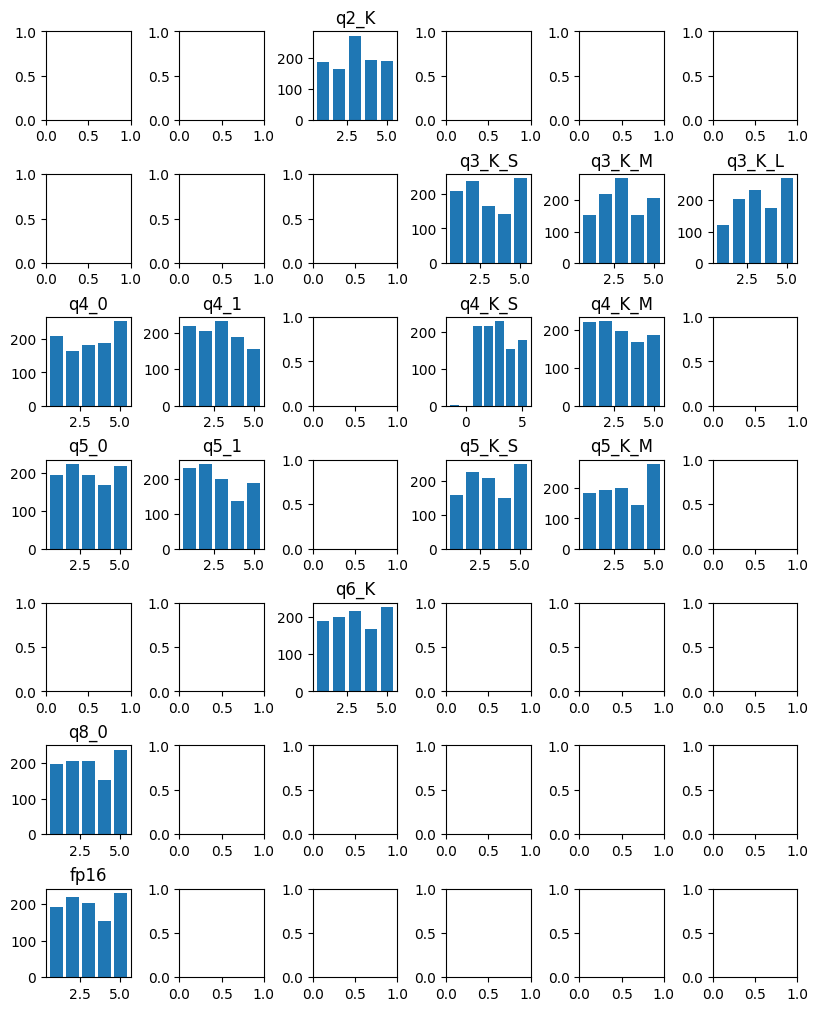

In [71]:
def plot_counts(experiment_path, title, ax=None):
    with open(experiment_path, 'r') as f:
        data = json.load(f)

    articles_numbers = [
        most_common([replica['parsed_response']['article_number'] for replica in sample if replica['parsed_response'] is not None])
        for sample in data['results']
    ]
    
    positions, counts = np.unique(articles_numbers, return_counts=True)

    if ax is None:
        ax = plt

    ax.bar(positions, counts)
    ax.set_title(title)

pos_map = {
    'q2_K':   (0, 2), # 3.2 GB
    'q3_K_S': (1, 3), # 3.7 GB
    'q3_K_M': (1, 4), # 4.0 GB
    'q3_K_L': (1, 5), # 4.3 GB
    'q4_0':   (2, 0), # 4.7 GB
    'q4_K_S': (2, 3), # 4.7 GB
    'q4_K_M': (2, 4), # 4.9 GB
    'q4_1':   (2, 1), # 5.1 GB
    'q5_0':   (3, 0), # 5.6 GB
    'q5_K_S': (3, 3), # 5.6 GB
    'q5_K_M': (3, 4), # 5.7 GB
    'q5_1':   (3, 1), # 6.1 GB
    'q6_K':   (4, 2), # 6.6 GB
    'q8_0':   (5, 0), # 8.5 GB
    'fp16':   (6, 0)  # 16 GB
}

fig, ax = plt.subplots(7, 6, constrained_layout=True, figsize=(8,10))

for q_level in pos_map:
    experiment_path = os.path.join(base_dir, f'{model_name}:{model_version}-{q_level}.json')
    row, col = pos_map[q_level]
    plot_counts(experiment_path, q_level, ax[row][col])

plt.show()

In [64]:
data_path = '../results/variance_reduction/icl_order__quantization_level__top_20/llama3.1:8b-instruct-q2_K.json'
with open(data_path, 'r') as f:
    d = json.load(f)
len(d['results'])

309

# Attack analysis

In [67]:
from sklearn.metrics import accuracy_score
import json
import os

# results_path = os.path.join('..', 'results', 'self_bias_analysis', 'baseline__no_attack', 'evaluation.json')
results_path = os.path.join('..', 'results', 'self_bias_analysis', 'tree_attack__6_4', 'eval_results.json')

with open(results_path, 'r') as f:
    results = json.load(f)

# Filter invalid results
results['results'] = [query_info for query_info in results['results'] if query_info['predicted_pos'] is not None]

# Get target and predicted positions
target_pos = [query_info['attack_pos'] for query_info in results['results']]
pred_pos = [query_info['predicted_pos'] for query_info in results['results']]

# Compute accuracy
accuracy = accuracy_score(target_pos, pred_pos)

accuracy

0.17806841046277666

In [14]:
from treelib import Node, Tree
import json
import os

def load_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

In [68]:
results_dir = os.path.join('..', 'results', 'self_bias_analysis', 'tree_attack__6_4__70b')

tree_path = os.path.join(results_dir, 'tree.json')
evaluations_dir = os.path.join(results_dir, 'evaluations')
tree_data = load_json(tree_path)

def parse_tree(tree, tree_data, evaluations_dir, parent_name=None):
    if tree_data is not None:
        for nodename, subtree_data in tree_data.items():

            nodename = int(nodename)
            evaluation_path = os.path.join(evaluations_dir, f'{nodename:05d}.json')
            evaluation = load_json(evaluation_path)
            node_str = evaluation['metric_value']

            tree.create_node(node_str, nodename, parent=parent_name)

            parse_tree(tree, subtree_data, evaluations_dir, nodename)

tree = Tree()
parse_tree(tree, tree_data, evaluations_dir)

tree.show()

0.12
├── 0.04
├── 0.08
├── 0.1
└── 0.16
    ├── 0.08
    ├── 0.1
    ├── 0.1
    └── 0.14



In [35]:
def get_nodes_by_level(tree):
    levels = []
    for nid in tree.nodes.keys():
        level = tree.level(nid)
        assert level <= len(levels)
        if level == len(levels):
            levels.append([])
        levels[level].append(tree.get_node(nid))
    return levels

levels = get_nodes_by_level(tree)

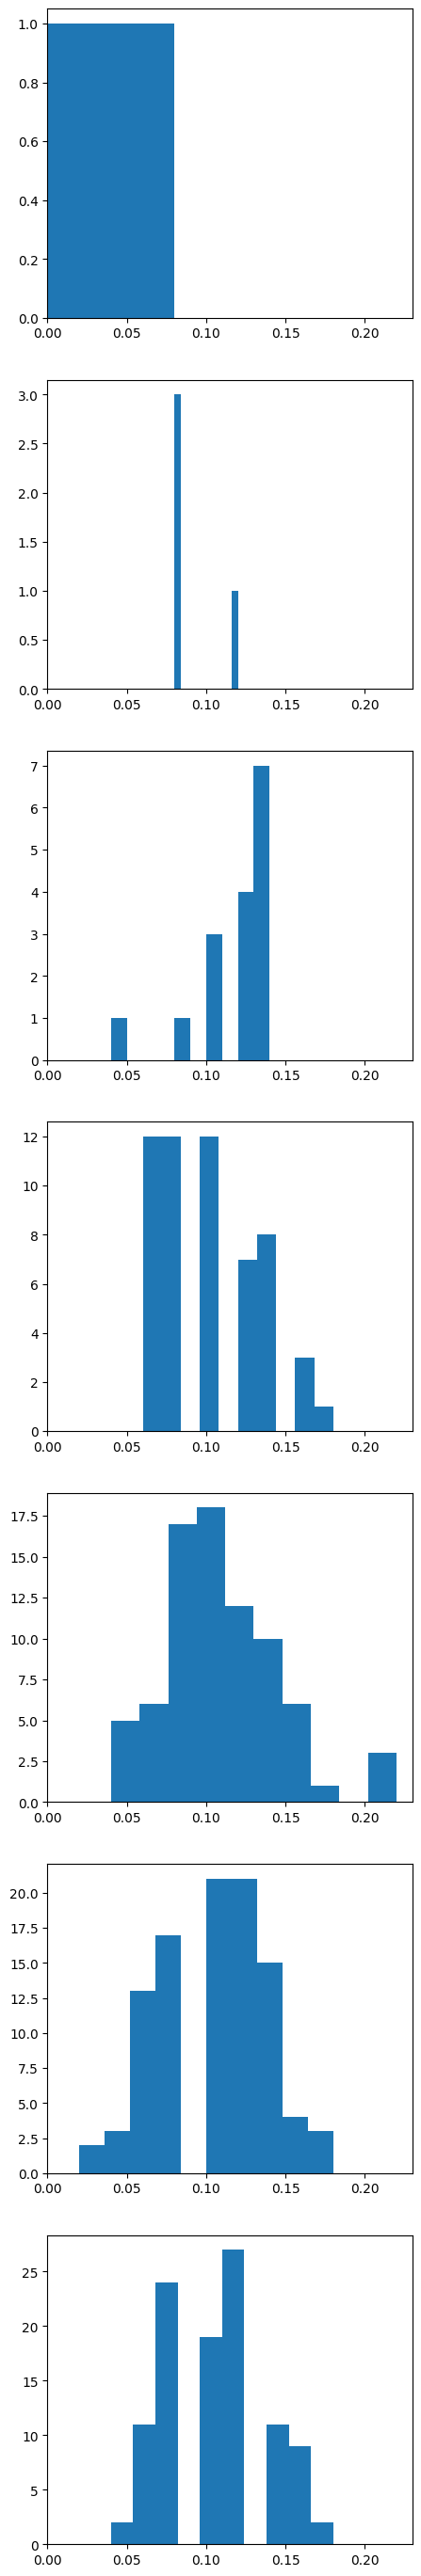

In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(levels), 1, figsize=(5, 5*len(levels)))

for i, level in enumerate(levels):
    level_scores = [node.tag for node in level if node.tag >= 0]
    ax[i].hist(level_scores)
    ax[i].set_xlim(0, 0.23)
plt.show()

# Recommender analysis

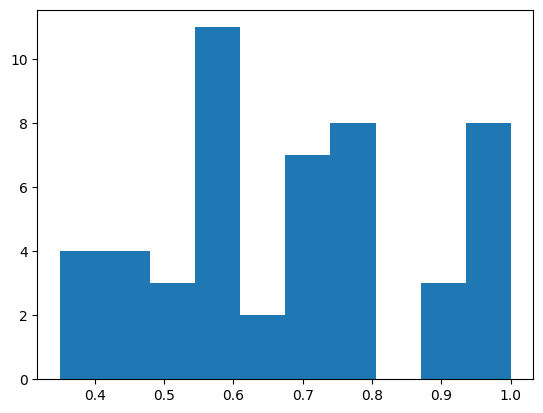

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

results_path = os.path.join('..', 'results', 'random_analysis', 'train_random_analysis.json')
with open(results_path, 'r') as f:
    results = json.load(f)

grouped = []
for i, sample_data in enumerate(results['results']):
    grouped_index = i % 20
    if grouped_index >= len(grouped):
        grouped.append([])
    grouped[grouped_index].append(sample_data['predicted_pos'])

grouped = np.array(grouped).T

recommender_results = []
for row in grouped:
    values, counts = np.unique(row, return_counts=True)
    metric_value = np.max(counts) / len(row)
    recommender_results.append(metric_value)

np.mean(recommender_results)

plt.hist(recommender_results)
plt.show()

In [34]:
print(results['results'][-1]['response'])

To recommend an energy-efficient light bulb to the user, I'll analyze each article based on its description.

1. Article 1: Crompton 3W LED Bulb - This is an LED bulb with a power consumption of 3 watts, which is relatively low.
2. Article 2: IVELECT 10Pcs Super Bright G4 12V 10w Tungsten Halogen Base Bulb Lamp Light Warm White - This article does not mention energy efficiency or low power consumption.
3. Article 3: Full Spectrum LED Grow Light Bulb, 60W 60LED Plant Grow Light Bulb for Indoor Plants Vegetables and Seedlings - Although this is an LED bulb, its power consumption is relatively high at 60 watts.
4. Article 4: Gramlite Base B22D Super Bright LED Bulb Non-Dimmable Cool Day Light 12-Watt for Home (Pack of 10, Cool White) - This article mentions that each bulb offers a lifespan of 15,000 hours and has a power consumption of 12 watts.
5. Article 5: FP21/865/ECO (2 Pack) 21 Watt T5 Fluorescent Tube Light Bulb 21W Daylight 6500K F21T5 Replaces - This article does not mention ener

In [35]:
print(results['results'][-2]['response'])

To recommend an energy-conserving light bulb to the user, I'll analyze each article based on its description.

1. Article 1: Crompton 3W LED Bulb - This is an LED bulb that has a longer shelf life compared to normal incandescent lamps and is resistant to shocks.
2. Article 2: IVELECT 10Pcs Super Bright G4 12V 10w Tungsten Halogen Base Bulb Lamp Light Warm White - This article does not explicitly mention energy conservation, but it's a halogen bulb which generally consumes more power than LED bulbs.
3. Article 3: Full Spectrum LED Grow Light Bulb, 60W 60LED Plant Grow Light Bulb for Indoor Plants Vegetables and Seedlings - Although this is an LED grow light, its primary purpose is for plant growth, not general lighting.
4. Article 4: Gramlite Base B22D Super Bright LED Bulb Non-Dimmable Cool Day Light 12-Watt for Home (Pack of 10, Cool White) - This article explicitly mentions energy efficiency and has a lower wattage compared to traditional bulbs.
5. Article 5: FP21/865/ECO (2 Pack) 21

# Generative model bias

evaluation_llama8b.json llama3.1:8b-instruct-fp16
../data/eval_models_and_products_dataset/model_bias_dataset__big.json
Chi2 stat: 1172.8643566246658, p-value: 1.2153424881847918e-252



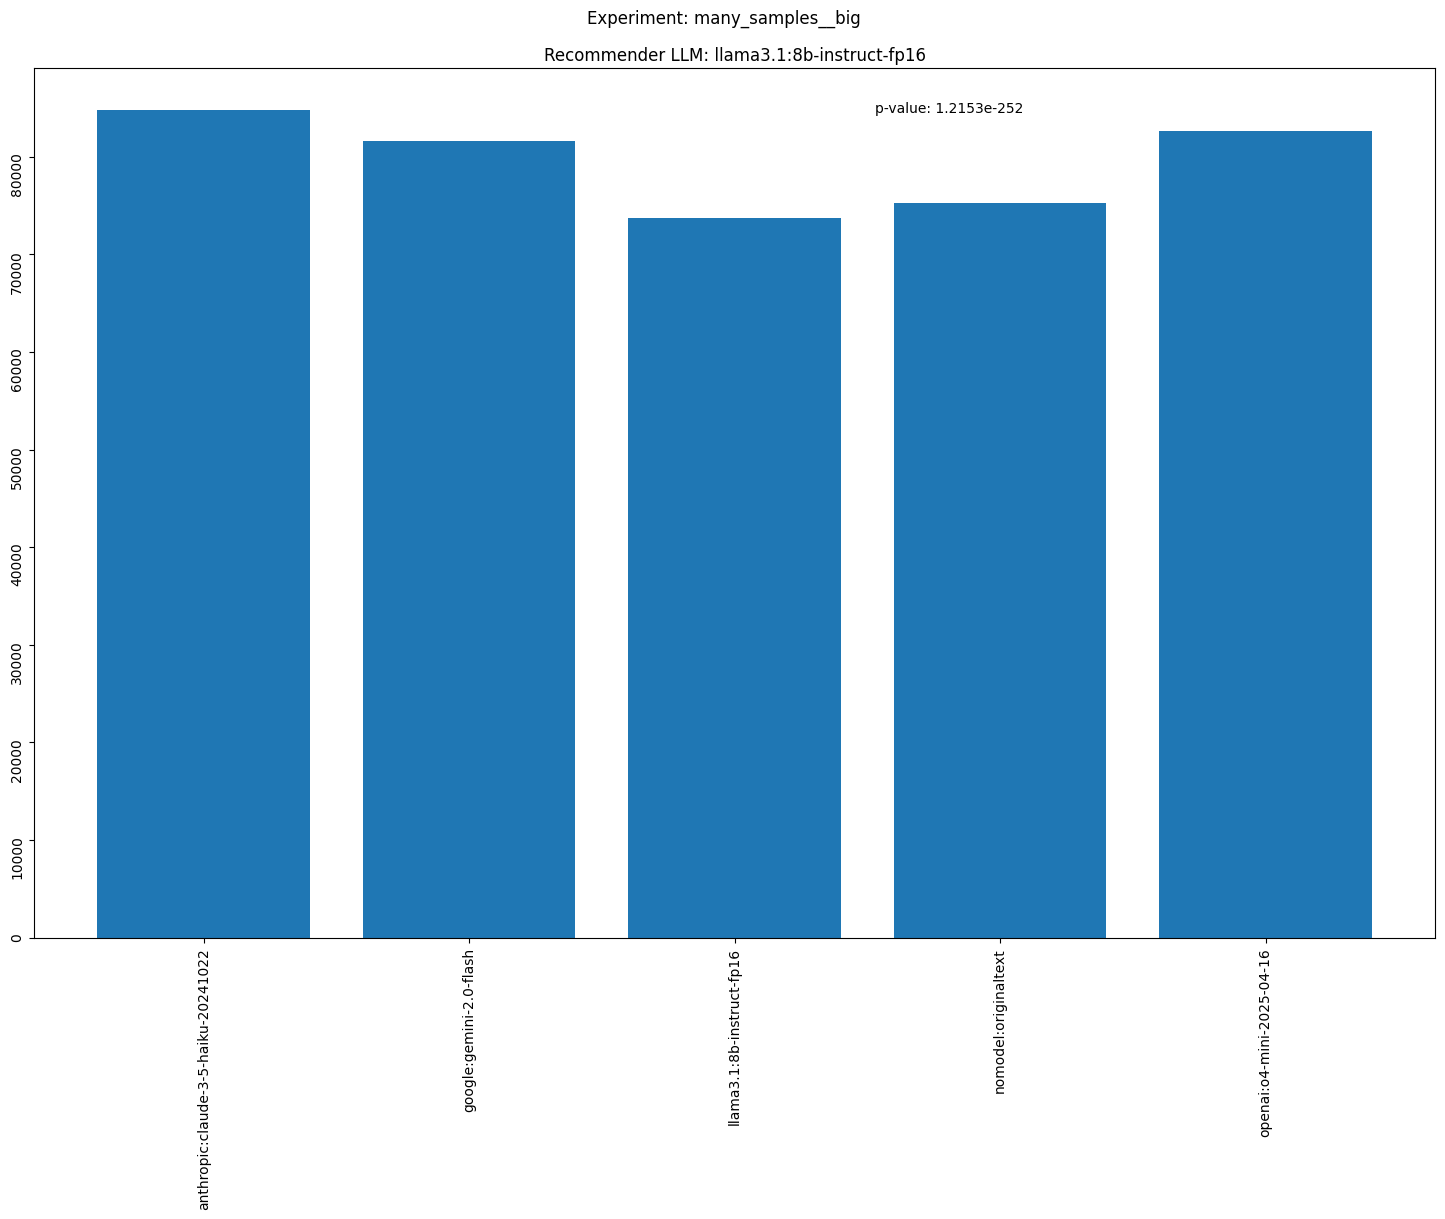

In [9]:
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chisquare
import numpy as np
import matplotlib.pyplot as plt
import json
import os

experiment_name = 'many_samples__big'
results_dir = os.path.join('..', 'results', 'self_bias_analysis', 'many_products_paraphrase', experiment_name)
filenames = list(os.listdir(results_dir))

ncols = 1
nrows = len(filenames) // ncols if len(filenames)%ncols == 0 else 1+(len(filenames)//ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10))

if isinstance(axs, np.ndarray):
    axs = axs.flatten().tolist()
else:
    axs = [axs]

fig.suptitle(f'Experiment: {experiment_name}')
fig.tight_layout(h_pad=20, pad=2)

start_pos = 2

for recommender_results_filename, ax in zip(filenames, axs):
    results_path = os.path.join(results_dir, recommender_results_filename)
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    dataset_path = os.path.join('..', results['input_dataset'])
    with open(dataset_path, 'r') as f:
        dataset = json.load(f)
    
    chosen_pos = []
    chosen_llms = []
    chosen_groups = []
    for results_sample, query_info in zip(results['results'], dataset['queries']):
        pred_pos = results_sample['predicted_pos']
        if isinstance(pred_pos, str):
            continue
        if pred_pos is None or pred_pos-1 >= len(query_info['products']):
            continue
        pred_product = query_info['products'][pred_pos-1]
        chosen_llms.append(pred_product['model_name'])
        chosen_groups.append(pred_product['model_group'])
        chosen_pos.append(pred_pos-1)

    # Compute p-value to test if the distribution is uniform
    n_models = len(dataset['queries'][0]['products'])
    chosen_llms_ids = LabelEncoder().fit_transform(chosen_llms)
    counts = np.bincount(chosen_llms_ids, minlength=n_models)
    expected = [len(chosen_llms_ids)/n_models] * n_models
    chi2_stat, p_value = chisquare(counts, f_exp=expected)

    print(recommender_results_filename, results["recommender_llm"])
    print(dataset_path)
    print(f"Chi2 stat: {chi2_stat}, p-value: {p_value}")
    print()
    
    x, count = np.unique(chosen_llms, return_counts=True)
    ax.bar(x, count)
    ax.tick_params(labelrotation=90)
    ax.set_title(f'Recommender LLM: {results["recommender_llm"]}')
    ax.text(x=0.6, y=0.95, s=f"p-value: {p_value:.5g}", transform=ax.transAxes, color='red' if p_value > 0.05 else 'black')

    """
    x, count = np.unique(chosen_groups, return_counts=True)
    ax.bar(x, count)
    ax.xticks(rotation=90)
    ax.title(f'Recommender LLM: {results["recommender_llm"]}')
    """

plt.show()

# Position bias analysis

In [38]:
import numpy as np
import json
import math
import os

experiment_name = 'position_bias__share'
filename = 'evaluation_llama8b.json'
results_dir = os.path.join('..', 'results', 'self_bias_analysis', 'many_products_paraphrase', experiment_name, filename)

with open(results_dir, 'r') as f:
    data = json.load(f)

input_dataset_path = os.path.join('..', data['input_dataset'])
results = data['results']

with open(input_dataset_path, 'r') as f:
    input_dataset = json.load(f)

top_k = input_dataset['top_k']
samples_per_query = input_dataset['samples_per_query']
if samples_per_query == 0:
    samples_per_query = math.factorial(top_k)

# This is required by the statistical test
assert input_dataset['share_permutations']

skipped_samples = list()
skipped_queries = set()
for i,result_sample in enumerate(results):
    pred_pos = result_sample['predicted_pos']
    if pred_pos is None or pred_pos < 1 or pred_pos > top_k:
        skipped_queries.add(i // samples_per_query)
        skipped_samples.append(i)


skip_samples = True
skip_queries = False
contingency_matrix = np.zeros((top_k, samples_per_query))

for i,(result_sample,query_info) in enumerate(zip(results, input_dataset['queries'])):
    query_id = i//samples_per_query
    permutation_id = i%samples_per_query

    if skip_samples and i in skipped_samples:
        continue
    if skip_queries and query_id in skipped_queries:
        continue

    pred_pos = result_sample['predicted_pos'] - 1
    true_pred_pos = query_info['permutation'][pred_pos]
    contingency_matrix[true_pred_pos,permutation_id] += 1
    # contingency_matrix[pred_pos,permutation_id] += 1

In [29]:
from scipy.stats import chi2_contingency

shuffles_subsample_size = 120
num_queries = len(input_dataset['queries']) // samples_per_query

# Generate a subsample
shuffles_subsample_indices = np.arange(samples_per_query)
np.random.shuffle(shuffles_subsample_indices)
shuffles_subsample_indices = shuffles_subsample_indices[:shuffles_subsample_size]

contingency_matrix_test = contingency_matrix.copy()
contingency_matrix_test = contingency_matrix_test[:,shuffles_subsample_indices]

# Run chi-squared test for independence
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_matrix_test, correction=False)

# Output results
print(f"Chi-squared statistic: {chi2_stat:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject the null hypothesis: distributions differ across permutations.")
else:
    print("Fail to reject the null hypothesis: no evidence that y affects the distribution.")

cramers_v = np.sqrt(chi2_stat / (np.sum(contingency_matrix_test) * (min(contingency_matrix_test.shape) - 1)))
print("Cramér’s V:", cramers_v)

np.sum(contingency_matrix)

Chi-squared statistic: 2903.9542
Degrees of freedom: 476
P-value: 0.0000
Reject the null hypothesis: distributions differ across permutations.
Cramér’s V: 0.07796032204054451


119449.0

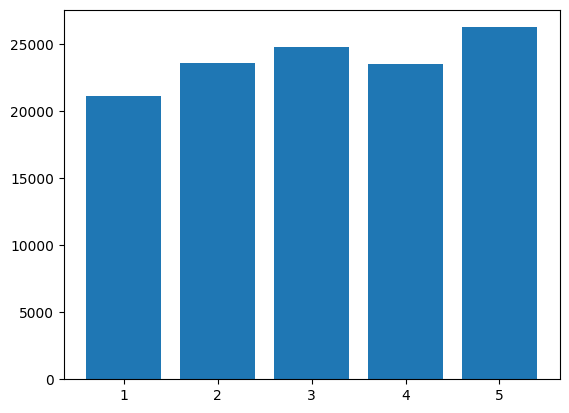

array([21164., 23639., 24840., 23526., 26280.])

In [34]:
plt.bar(range(1, top_k+1), np.sum(contingency_matrix, axis=1))
plt.savefig(f"../figures/raw_probability_distribution.pdf", format="pdf", bbox_inches="tight")
plt.show()

np.sum(contingency_matrix, axis=1)

In [8]:
contingency_matrix.shape

(5, 120)

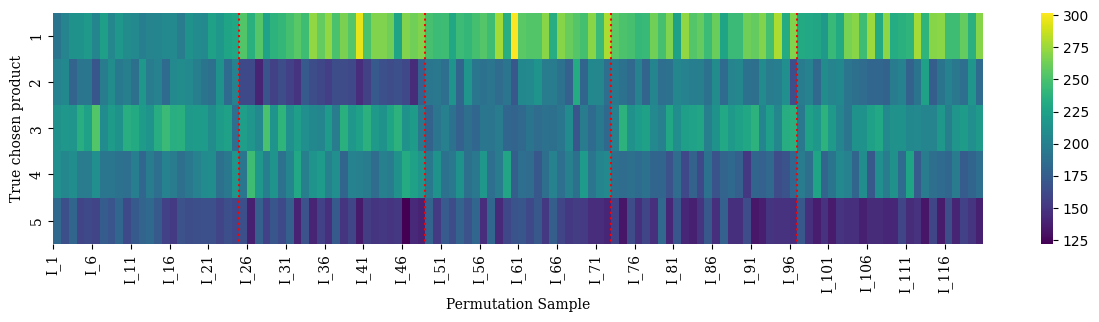

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

swap_axes = False

fig, ax = plt.subplots(figsize=(8, 10) if swap_axes else (15, 3))
sns.heatmap(contingency_matrix.T if swap_axes else contingency_matrix, cmap="viridis", ax=ax)

for i in range(1, top_k):
    ax.plot([0, top_k] if swap_axes else [24*i, 24*i], [24*i, 24*i] if swap_axes else [0, top_k], linestyle = 'dotted', color='red')

step = 5
tick_locs = list(range(0, samples_per_query, step))
tick_labels = [f"I_{s+1}" for s in tick_locs]

set_xticklabels = ax.set_yticklabels if swap_axes else ax.set_xticklabels
set_xticks = ax.set_yticks if swap_axes else ax.set_xticks
set_yticklabels = ax.set_xticklabels if swap_axes else ax.set_yticklabels
set_yticks = ax.set_xticks if swap_axes else ax.set_yticks
set_xlabel = ax.set_ylabel if swap_axes else ax.set_xlabel
set_ylabel = ax.set_xlabel if swap_axes else ax.set_ylabel

font_config = {'fontname':'Serif'}

set_yticklabels(range(1, top_k+1), **font_config)
set_xticks(tick_locs)
set_xticklabels(tick_labels, **font_config)

set_ylabel("True chosen product", **font_config)
set_xlabel("Permutation Sample", **font_config)
# ax.set_title("True chosen product Distribution per Permutation", **font_config)

plt.savefig(f"../figures/all_distribution_probabilities__{'vertical' if swap_axes else 'horizontal'}.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [14]:
import matplotlib.pyplot as plt

def compute_blocks(product_pos, top_k, samples_per_query, input_dataset):
    blocks = []
    for block_pos in range(top_k):
        blocks.append([])
        for i in range(samples_per_query):
            permutation = input_dataset['queries'][i]['permutation']
            if permutation[product_pos] == block_pos:
                blocks[-1].append(i)
    return blocks

"""
for product_pos in range(top_k):
    fig, axs = plt.subplots(2, 3, figsize=(8, 6))
    axs = axs.ravel()
    
    blocks = compute_blocks(product_pos, top_k, samples_per_query, input_dataset)

    print('###################################\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n')
    
    for block_pos in range(top_k):
        # axs[block_pos].bar(range(top_k), contingency_matrix[:,block_pos*(samples_per_query//top_k):(block_pos+1)*(samples_per_query//top_k)].mean(axis=1))
        axs[block_pos].bar(range(top_k), contingency_matrix[:,blocks[block_pos]].mean(axis=1))
        axs[block_pos].set_title(f'Product {product_pos+1} in position {block_pos+1}')
    plt.show()
"""

"\nfor product_pos in range(top_k):\n    fig, axs = plt.subplots(2, 3, figsize=(8, 6))\n    axs = axs.ravel()\n    \n    blocks = compute_blocks(product_pos, top_k, samples_per_query, input_dataset)\n\n    print('###################################\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n')\n    \n    for block_pos in range(top_k):\n        # axs[block_pos].bar(range(top_k), contingency_matrix[:,block_pos*(samples_per_query//top_k):(block_pos+1)*(samples_per_query//top_k)].mean(axis=1))\n        axs[block_pos].bar(range(top_k), contingency_matrix[:,blocks[block_pos]].mean(axis=1))\n        axs[block_pos].set_title(f'Product {product_pos+1} in position {block_pos+1}')\n    plt.show()\n"

[]

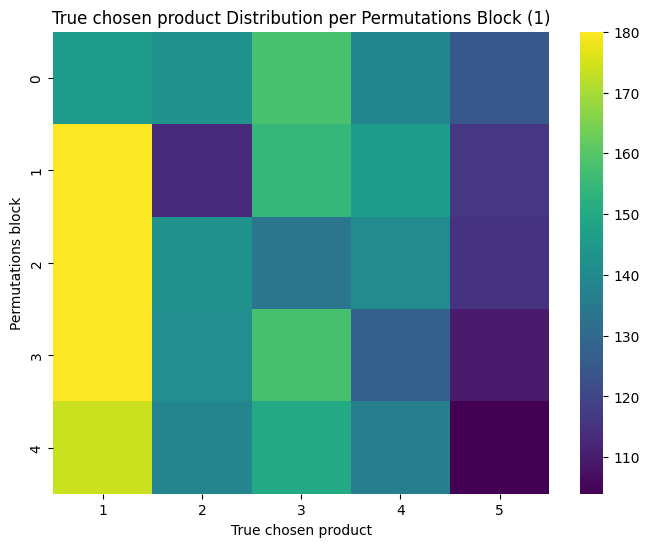

In [75]:
import seaborn as sns

def compress_list(l):
    l = sorted(l)
    result = str(l[0])
    for i in range(1, len(l)):
        if l[i] != l[i-1]+1:
            result += f'..{l[i-1]},{l[i]}'
    if len(l) > 1 and l[-1] == l[-2]+1:
        result += f'..{l[-1]}'
    return result

def compute_blocks_medians(target_pos, top_k, samples_per_query, input_dataset):
    blocks = np.array(compute_blocks(target_pos, top_k, samples_per_query, input_dataset))
    blocks_medians = []
    for block_permutations in blocks:
        block = contingency_matrix[:, block_permutations].T
        medians = np.median(block, axis=0)
        blocks_medians.append(medians)
    blocks_medians = np.array(blocks_medians)
    return blocks_medians
    

target_pos = 0
blocks_medians = compute_blocks_medians(target_pos, top_k, samples_per_query, input_dataset)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(blocks_medians, cmap="viridis", ax=ax)

ax.set_xticklabels(range(1, top_k+1))
# ax.set_yticklabels([f"I_{{{compress_list(block_permutations)}}}" for block_permutations, i in zip(blocks, range(blocks_medians.shape[0]))])

ax.set_xlabel("True chosen product")
ax.set_ylabel("Permutations block")
ax.set_title(f"True chosen product Distribution per Permutations Block ({target_pos+1})")

plt.plot()

[]

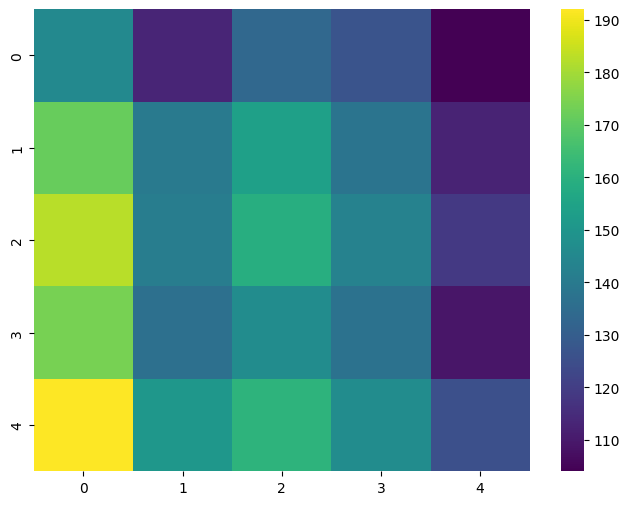

In [31]:
diagonals = []
for target_pos in range(top_k):
    medians = compute_blocks_medians(target_pos, top_k, samples_per_query, input_dataset)
    diagonals.append(medians.diagonal())
diagonals = np.array(diagonals)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(diagonals, cmap="viridis", ax=ax)

plt.plot()

In [29]:
# Debug block generation
debug_permutations = []
for i in range(samples_per_query):
    debug_permutations.append(input_dataset['queries'][i]['permutation'])
debug_permutations = np.array(debug_permutations)

for target_pos in range(top_k):

    for i in range(top_k):
        print(f"Product {i} to Position {target_pos}", end='    ')
    print()

    for col in np.array(compute_blocks(target_pos, top_k, samples_per_query, input_dataset)).T:
        block_permutations = debug_permutations[col, :]
        for permutation in block_permutations:
            print(permutation, end='                ')
        print()

    print("\n\n")

Product 0 to Position 0    Product 1 to Position 0    Product 2 to Position 0    Product 3 to Position 0    Product 4 to Position 0    
[0 1 2 3 4]                [1 0 2 3 4]                [2 0 1 3 4]                [3 0 1 2 4]                [4 0 1 2 3]                
[0 1 2 4 3]                [1 0 2 4 3]                [2 0 1 4 3]                [3 0 1 4 2]                [4 0 1 3 2]                
[0 1 3 2 4]                [1 0 3 2 4]                [2 0 3 1 4]                [3 0 2 1 4]                [4 0 2 1 3]                
[0 1 3 4 2]                [1 0 3 4 2]                [2 0 3 4 1]                [3 0 2 4 1]                [4 0 2 3 1]                
[0 1 4 2 3]                [1 0 4 2 3]                [2 0 4 1 3]                [3 0 4 1 2]                [4 0 3 1 2]                
[0 1 4 3 2]                [1 0 4 3 2]                [2 0 4 3 1]                [3 0 4 2 1]                [4 0 3 2 1]                
[0 2 1 3 4]                [1 2 0 3 4]          

In [19]:
np.array(compute_blocks(0, top_k, samples_per_query, input_dataset))

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23],
       [ 24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
         37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47],
       [ 48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
         61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71],
       [ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95],
       [ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]])

[]

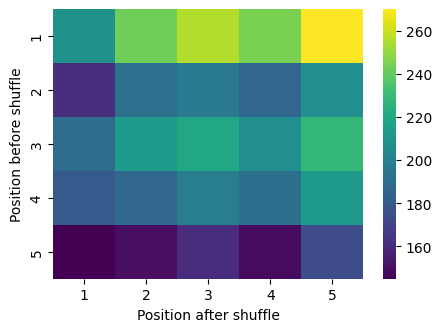

In [87]:
# Input: array of shape (top_k, samples_per_query)
#  - Each column represents the probability distribution (non-normalized) of selecting 
#    the ith-product (i is the row)
# contingency_matrix

# Output: array of shape (top_k, top_k)
#  - Each row represents the medians of counts of selected products that were on position i (row) and
#    was moved to position j (column)
matrix_counts = np.zeros((top_k, top_k))


for orig_pos in range(top_k):

    test_set = set()

    for target_pos in range(top_k):

        # Array of shape (top_k, samples_per_query//top_k)
        #  - Each ith-row (block) represents a set of indices of shuffles, 
        #    where these shuffles moves products from position i to target_pos
        blocks = np.array(compute_blocks(target_pos, top_k, samples_per_query, input_dataset))

        # List of counts (each one is like a sample), where the selected product was at orig_pos, 
        # was moved to the target_pos and it was selected by the model
        counts = contingency_matrix[orig_pos, blocks[orig_pos]]
        test_set.update(blocks[orig_pos])
        
        # Compute the mean for a robust representation
        median = np.median(counts)

        matrix_counts[orig_pos, target_pos] = median

    assert len(test_set) == samples_per_query

fig, ax = plt.subplots(figsize=(5, 3.5))
sns.heatmap(matrix_counts, cmap="viridis", ax=ax)

ax.set_xticklabels(range(1, top_k+1))
ax.set_yticklabels(range(1, top_k+1))

ax.set_xlabel('Position after shuffle')
ax.set_ylabel('Position before shuffle')

plt.savefig(f"../figures/bias_analysis.pdf", format="pdf", bbox_inches="tight")

plt.plot()

In [37]:
120000 - np.sum(contingency_matrix)

551.0